In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [ ]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((48, 48)), 
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),   
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))  
])

In [ ]:
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((48, 48)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

In [ ]:


train_data_path = r"C:\Users\Za-M\Desktop\emotion\emotion_detection\DATA\train"
test_data_path = r"C:\Users\Za-M\Desktop\emotion\emotion_detection\DATA\test"

In [ ]:
import os


print("Train Directory Exists:", os.path.isdir(train_data_path))
print("Test Directory Exists:", os.path.isdir(test_data_path))

print("Train Subdirectories:", os.listdir(train_data_path))
print("Test Subdirectories:", os.listdir(test_data_path))


Train Directory Exists: True
Test Directory Exists: True
Train Subdirectories: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Test Subdirectories: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  
        self.fc2 = nn.Linear(256, len(train_dataset.classes))  
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))  
        x = x.view(-1, 128 * 6 * 6)  
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:

model = EmotionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:

best_loss = float('inf')
patience = 5  
counter = 0

In [ ]:

train_losses = []
train_accuracies = []

In [ ]:
epochs = 30 
for epoch in range(epochs):
    model.train()  
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
       
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
    
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping on epoch {epoch+1}')
        break


Epoch [1/30], Loss: 1.6925, Accuracy: 0.3214
Epoch [2/30], Loss: 1.4972, Accuracy: 0.4257
Epoch [3/30], Loss: 1.3883, Accuracy: 0.4695
Epoch [4/30], Loss: 1.3210, Accuracy: 0.4961
Epoch [5/30], Loss: 1.2862, Accuracy: 0.5173
Epoch [6/30], Loss: 1.2518, Accuracy: 0.5289
Epoch [7/30], Loss: 1.2169, Accuracy: 0.5379
Epoch [8/30], Loss: 1.2017, Accuracy: 0.5500
Epoch [9/30], Loss: 1.1818, Accuracy: 0.5528
Epoch [10/30], Loss: 1.1674, Accuracy: 0.5639
Epoch [11/30], Loss: 1.1503, Accuracy: 0.5654
Epoch [12/30], Loss: 1.1374, Accuracy: 0.5726
Epoch [13/30], Loss: 1.1275, Accuracy: 0.5744
Epoch [14/30], Loss: 1.1158, Accuracy: 0.5787
Epoch [15/30], Loss: 1.1069, Accuracy: 0.5808
Epoch [16/30], Loss: 1.1015, Accuracy: 0.5825
Epoch [17/30], Loss: 1.0890, Accuracy: 0.5892
Epoch [18/30], Loss: 1.0812, Accuracy: 0.5908
Epoch [19/30], Loss: 1.0731, Accuracy: 0.5910
Epoch [20/30], Loss: 1.0644, Accuracy: 0.5965
Epoch [21/30], Loss: 1.0607, Accuracy: 0.5978
Epoch [22/30], Loss: 1.0486, Accuracy: 0.60

In [ ]:

plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

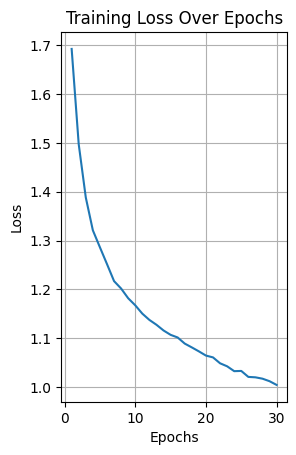

In [ ]:

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)


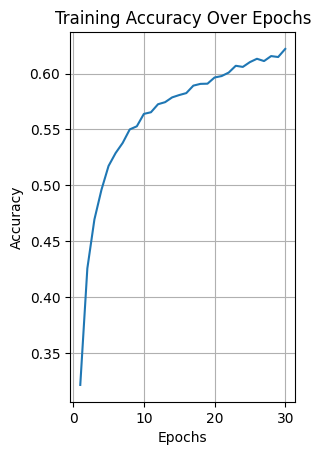

In [ ]:

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.grid(True)


In [16]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:

def evaluate_model(model, data_loader):
    model.eval()  
    all_preds = []
    all_labels = []
    with torch.no_grad():  
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    
    
    cm = confusion_matrix(all_labels, all_preds)
    
   
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

Accuracy: 0.6120
Precision: 0.6096
Recall: 0.6120
F1 Score: 0.6057


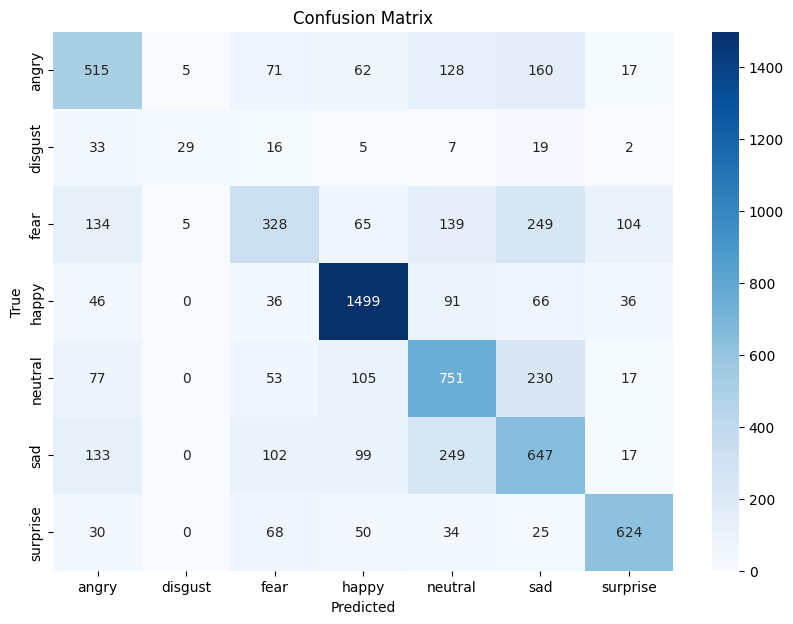

(0.6120089161326274,
 0.6096127042840549,
 0.6120089161326274,
 0.6057177133287139)

In [ ]:

evaluate_model(model, test_loader)

In [ ]:

torch.save(model.state_dict(), r"C:\Users\Za-M\Desktop\emotion\emotion_detection\emotion_cnn_model.pth")


In [ ]:

model = EmotionCNN()
model.load_state_dict(torch.load(r"C:\Users\Za-M\Desktop\emotion\emotion_detection\emotion_cnn_model.pth"))
model.eval()  

EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)